# Downscaling paper Figure 10

In [85]:
import xarray as xr
import pandas as pd
import numpy as np
import gcsfs
import itertools

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

In [86]:
fps = {'precip_clean':'gs://downscaled-288ec5ac/diagnostics/paper_figures/global_means_gdpcir_versus_source/precip_clean.zarr',
       'precip_gdpcir':'gs://downscaled-288ec5ac/diagnostics/paper_figures/global_means_gdpcir_versus_source/precip_gdpcir.zarr',
       'tasmax_clean':'gs://downscaled-288ec5ac/diagnostics/paper_figures/global_means_gdpcir_versus_source/tasmax_clean.zarr',
       'tasmax_gdpcir':'gs://downscaled-288ec5ac/diagnostics/paper_figures/global_means_gdpcir_versus_source/tasmax_gdpcir.zarr'
      }

In [87]:
MODELS_BY_LICENSE = {
    "cc0": [
        "FGOALS-g3",
        "INM-CM4-8",
        "INM-CM5-0",
    ],
    "cc_by": [
        "ACCESS-CM2",
        "ACCESS-ESM1-5",
        "BCC-CSM2-MR",
        "CMCC-CM2-SR5",
        "CMCC-ESM2",
        "EC-Earth3-AerChem",
        "EC-Earth3-CC",
        "EC-Earth3-Veg-LR",
        "EC-Earth3-Veg",
        "EC-Earth3",
        "GFDL-CM4",
        "GFDL-ESM4",
        "HadGEM3-GC31-LL",
        "MIROC-ES2L",
        "MIROC6",
        "MPI-ESM1-2-HR",
        "MPI-ESM1-2-LR",
        "NESM3",
        "NorESM2-LM",
        "NorESM2-MM",
        "UKESM1-0-LL",
    ],
    "cc_by_sa": [
        "CanESM5",
    ]
}

ALL_MODELS = sum(MODELS_BY_LICENSE.values(), [])

### Quick diagnostic of the precip trend diffs.

In [88]:
diffs = (xr.open_zarr(fps['precip_gdpcir']).da.sel(scenario='ssp370').squeeze('step')-xr.open_zarr(fps['precip_clean']).da.sel(scenario='ssp370').squeeze('step')).load()

In [89]:
mydict = {}
for m in diffs.model.values:
    mydict[m] = np.round(diffs.sel(model=m).values.item(),3)

In [90]:
mydict

{'ACCESS-CM2': 0.034,
 'ACCESS-ESM1-5': 0.022,
 'BCC-CSM2-MR': -0.01,
 'CMCC-CM2-SR5': 0.035,
 'CMCC-ESM2': 0.028,
 'CanESM5': 0.069,
 'EC-Earth3': 0.056,
 'EC-Earth3-Veg': 0.055,
 'EC-Earth3-Veg-LR': 0.039,
 'FGOALS-g3': 0.012,
 'GFDL-ESM4': 0.017,
 'INM-CM4-8': 0.04,
 'INM-CM5-0': 0.04,
 'MIROC-ES2L': 0.053,
 'MIROC6': 0.022,
 'MPI-ESM1-2-LR': 0.04,
 'NorESM2-LM': 0.065,
 'NorESM2-MM': 0.036,
 'UKESM1-0-LL': 0.028}

## Making the plot

In [94]:
precip_clean = xr.open_zarr(fps['precip_clean']).da.load()
precip_gdpcir = xr.open_zarr(fps['precip_gdpcir']).da.load()
tasmax_clean = xr.open_zarr(fps['tasmax_clean']).da.load() 
tasmax_gdpcir = xr.open_zarr(fps['tasmax_gdpcir']).da.load()

In [95]:
precip_clean

<xarray.DataArray 'da' (scenario: 2, model: 20, step: 1)>
array([[[1.0770249 ],
        [1.0401354 ],
        [1.0190923 ],
        [1.0898944 ],
        [1.080697  ],
        [1.080205  ],
        [1.0617529 ],
        [1.0539725 ],
        [1.0516118 ],
        [1.010331  ],
        [1.0216612 ],
        [1.0560522 ],
        [1.0451517 ],
        [1.0684373 ],
        [1.0504359 ],
        [1.0406654 ],
        [1.0248696 ],
        [1.0008407 ],
        [0.99885267],
        [1.0648216 ]],
...
       [[1.0859467 ],
        [1.0265708 ],
        [1.0316039 ],
        [1.0701864 ],
        [1.0707366 ],
        [1.0834572 ],
        [1.0960702 ],
        [1.0852121 ],
        [1.0734462 ],
        [1.0266646 ],
        [0.9753428 ],
        [1.0820323 ],
        [1.0709965 ],
        [1.0812978 ],
        [1.0517027 ],
        [1.0403992 ],
        [1.051922  ],
        [1.0116246 ],
        [1.0051167 ],
        [1.0737902 ]]], dtype=float32)
Coordinates:
  * model     (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * scenario  (scenario) <U6 'ssp245' 'ssp370'
  * step      (step) <U5 'clean'

In [96]:
markerlst = ["p", "d", "o", "*", "s", "v", ">", "P", "<", "8", "^", "H", "D", "X"]
colorlst = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
]


pspec = {}
for mii, mm in enumerate(ALL_MODELS):
    # assign marker and color
    pspec[mm] = (markerlst[mii % len(markerlst)], colorlst[mii % len(colorlst)])

In [97]:
PLOT_MODELS = tasmax_gdpcir.model.values

Text(0.5, 1.0, 'SSP3-7.0')

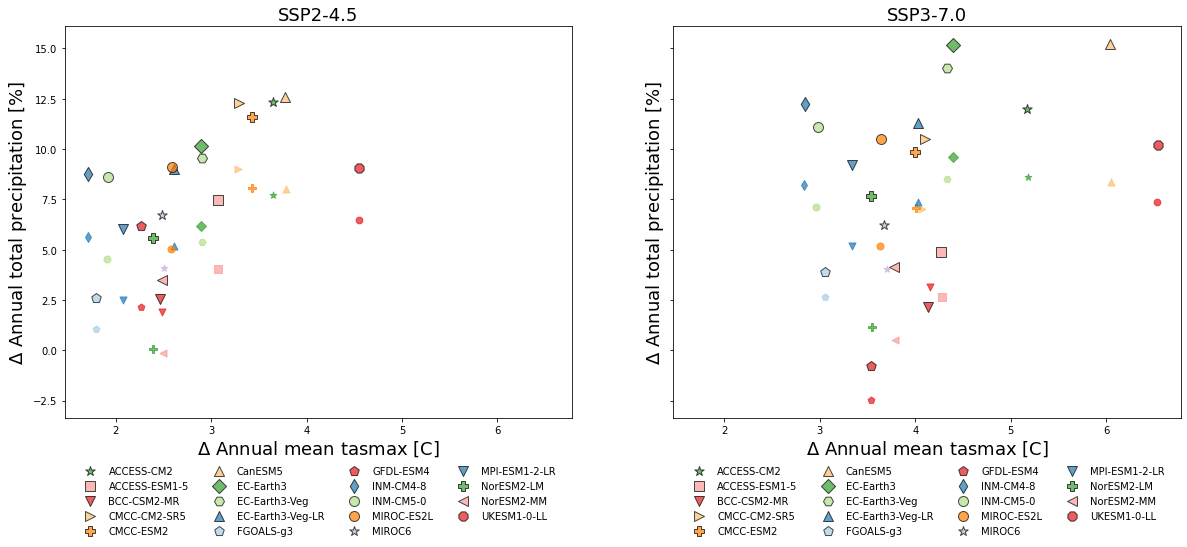

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

scen = "ssp245"
tplt = tasmax_gdpcir.copy(deep=True)
pplt = (precip_gdpcir.copy(deep=True)-1)*100
cltgm = tasmax_clean.copy(deep=True)
clpgm = (precip_clean.copy(deep=True)-1)*100
markers = itertools.cycle(markerlst) 
colors = itertools.cycle(colorlst) 
models45 = PLOT_MODELS
models4570 = PLOT_MODELS

ax = axs[0]

for mm in models45:

    plotx =  tplt.sel(model=mm, scenario=scen)
    ploty = pplt.sel(model=mm,scenario=scen)

    ax.scatter(plotx, ploty, s=100, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7,
               edgecolors="k")  

# ===
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend((models45),loc='upper center', bbox_to_anchor=(0.5, -0.1),
          frameon=False,fancybox=True, shadow=True, ncol=4)
# ===
for mm in models45:
    
    plotclx = cltgm.sel(model=mm, scenario=scen)
    plotcly = clpgm.sel(model=mm, scenario=scen)
    
    ax.scatter(plotclx, 
               plotcly, s=50, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7)  


ax.set_xlabel("$\Delta$ Annual mean tasmax [C]", fontsize=18)
ax.set_ylabel("$\Delta$ Annual total precipitation [%]", fontsize=18)
ax.set_title(f"SSP2-4.5", fontsize=18) # {ttl} \n2080-2099 change relative 1995-2014


scen = "ssp370"

markers = itertools.cycle(markerlst) 
colors = itertools.cycle(colorlst) 

ax = axs[1]

for mm in models4570:

    plotx = tplt.sel(scenario=scen, model=mm)
    ploty = pplt.sel(model=mm,scenario=scen)
    
    ax.scatter(plotx, ploty, s=100, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7,
               edgecolors="k")  

# ===
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend((models4570),loc='upper center', bbox_to_anchor=(0.5, -0.1),
          frameon=False,fancybox=True, shadow=True, ncol=4)
# ===
for mm in models4570:
    
    plotclx = cltgm.sel(scenario=scen, model=mm)
    plotcly = clpgm.sel(scenario=scen, model=mm)
    
    ax.scatter(plotclx, 
               plotcly, s=50, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7)  


ax.set_xlabel("$\Delta$ Annual mean tasmax [C]", fontsize=18)
ax.set_ylabel("$\Delta$ Annual total precipitation [%]", fontsize=18)
ax.set_title(f"SSP3-7.0", fontsize=18) # {ttl} \n2080-2099 change relative 1995-2014


# fig.savefig(f"downscaling_paper_figure10_ssp245_ssp370_{wtype}_ann_tasmax_v_totalpr_scatter_plot_2panelcolors_withcleancolors.png",dpi=120,bbox_inches="tight")

In [41]:
import sys

sys.path.append(".")

import dc6_functions as dc6

In [45]:
import yaml

with open('dcmip6_all_paths_all.yaml', 'r') as f:
    DC6_STAGE_PATHS = yaml.safe_load(f)

## Open compiled diagnostic data for scatter plot
These data produced in: `Figure10_scatter_data_prep.ipynb`

In [66]:
# open data files for diagnostic figures.
# TODO update this to a more useful location
SAVEDIR = "/gcs/impactlab-data/climate/downscaling/qc/kelly_diagnostics/"

tgm = {}
pgm = {}
cltgm = {}
clpgm = {}

for scen in ["ssp245", "ssp370", "historical"]:
    tgm[scen] = xr.open_dataset(
        f"{SAVEDIR}/annual_tasmax_diagnostics_{scen}_global_mean_timeseries_GCMS.nc"
    )
    pgm[scen] = xr.open_dataset(
        f"{SAVEDIR}/annual_precip_diagnostics_{scen}_global_mean_timeseries_GCMS.nc"
    )

    # clean models
    cltgm[scen] = xr.open_dataset(
        f"{SAVEDIR}/annual_tasmax_diagnostics_{scen}_global_mean_timeseries_cleanGCMS.nc"
    )
    clpgm[scen] = xr.open_dataset(
        f"{SAVEDIR}/annual_precip_diagnostics_{scen}_global_mean_timeseries_cleanGCMS.nc"
    )

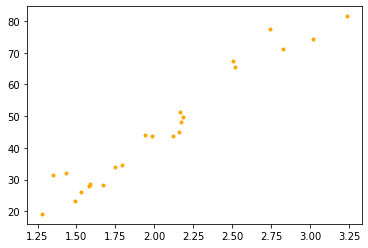

In [105]:
# testing testing
xplt = cltgm["ssp245"].sel(weighting="area-weighted", year=tslice).mean(
    dim="year"
) - cltgm["historical"].sel(weighting="area-weighted", year=slice(1995, 2014)).mean(
    dim="year"
)

yplt = clpgm["ssp245"].sel(weighting=wtype, year=tslice).mean(dim="year") - clpgm[
    "historical"
].sel(weighting=wtype, year=slice(1995, 2014)).mean(dim="year")

plt.scatter(
    xplt["annual_average_tasmax"],
    yplt["total_annual_precip"],
    color="orange",
    marker=".",
)

In [102]:
cltgm["ssp245"].sel(weighting="area-weighted")#,year=tslice).mean(dim="year")

<xarray.Dataset>
Dimensions:                 (year: 76, model: 24)
Coordinates:
  * year                    (year) int64 1950 1951 1952 1953 ... 2023 2024 2025
  * model                   (model) object 'BCC-CSM2-MR' ... 'EC-Earth3-Veg-LR'
    weighting               <U13 'area-weighted'
Data variables:
    annual_average_tasmax   (model, year) float64 289.9 290.1 ... 290.1 290.1
    annual_count_above_95F  (model, year) float64 13.37 14.28 ... 10.92 10.86

`land-area-weighted` and `pop-weighted` are both all `nan`s probably because the weights used to produce the weighted averages are not on the same grids as the native (cleaned) GCMs

In [83]:
(clpgm["ssp245"].sel(weighting="pop-weighted")["total_annual_precip"].isnull()).sum().values # all nans

array(2231)

In [88]:
(clpgm["ssp245"].sel(weighting="land-area-weighted")["total_annual_precip"].isnull()).sum().values # all nans

array(2231)

# Paper Figures

## Draft Fig 10 : scatter plot

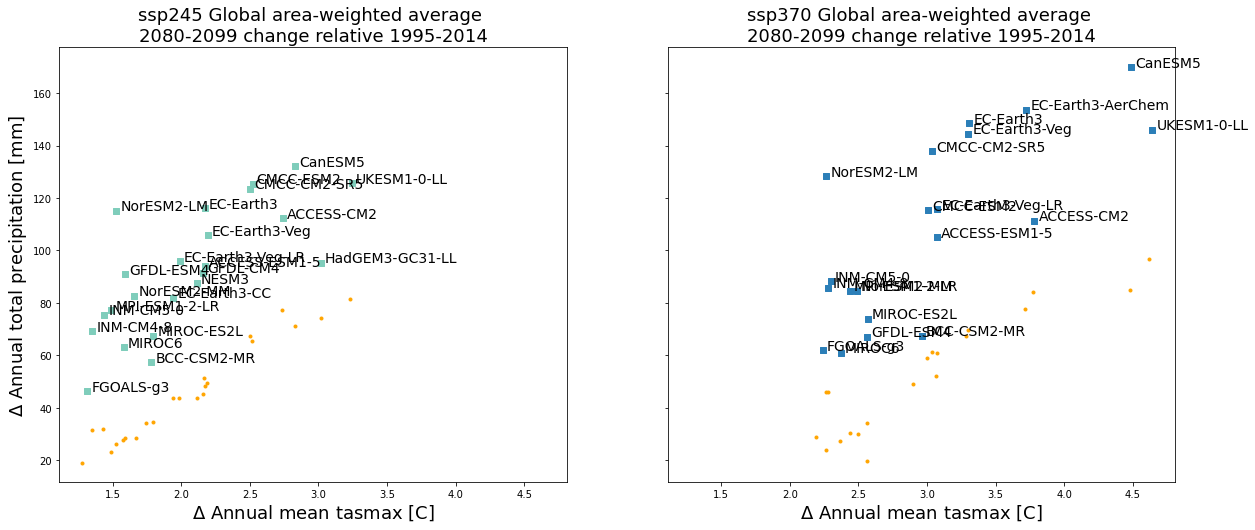

In [107]:
import itertools


wtype = "area-weighted"

scen = "historical"
thplt = tgm[scen].sel(weighting=wtype)["annual_average_tasmax"] - 273.15
phplt = pgm[scen].sel(weighting=wtype)["total_annual_precip"]

ttl = f"Global {wtype} average"


fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

scen = "ssp245"
tplt = tgm[scen].sel(weighting=wtype)["annual_average_tasmax"] - 273.15
pplt = pgm[scen].sel(weighting=wtype)["total_annual_precip"]
annotations = tplt.model.values

ax = axs[0]

tslice = slice(2080, 2099)
plotx = tplt.sel(year=tslice).mean(dim="year") - (thplt).sel(
    year=slice(1995, 2014)
).mean(dim="year")
ploty = pplt.sel(year=tslice).mean(dim="year") - (phplt).sel(
    year=slice(1995, 2014)
).mean(dim="year")
ax.scatter(
    plotx, ploty, marker="s", color="#7fcdbb"
)  # marker=next(markers), c=tplt.sel(year=slice(2080,2099)).year)

for i, label in enumerate(annotations):
    ax.annotate(label, (plotx.values[i] + 0.03, ploty.values[i] + 0.03), fontsize=14)
ax.set_xlabel("$\Delta$ Annual mean tasmax [C]", fontsize=18)
ax.set_ylabel("$\Delta$ Annual total precipitation [mm]", fontsize=18)
ax.set_title(f"{scen} {ttl} \n2080-2099 change relative 1995-2014", fontsize=18)

# ADD CLEAN MODELS
if wtype == "area-weighted":  # all nans otherwise
    xplt = cltgm[scen].sel(weighting=wtype, year=tslice).mean(dim="year") - cltgm[
        "historical"
    ].sel(weighting=wtype, year=slice(1995, 2014)).mean(dim="year")

    yplt = clpgm[scen].sel(weighting=wtype, year=tslice).mean(dim="year") - clpgm[
        "historical"
    ].sel(weighting=wtype, year=slice(1995, 2014)).mean(dim="year")

    ax.scatter(
        xplt["annual_average_tasmax"],
        yplt["total_annual_precip"],
        color="orange",
        marker=".",
    )

scen = "ssp370"
tplt = tgm[scen].sel(weighting=wtype)["annual_average_tasmax"] - 273.15
pplt = pgm[scen].sel(weighting=wtype)["total_annual_precip"]
annotations = tplt.model.values

ax = axs[1]
tslice = slice(2080, 2099)
plotx = tplt.sel(year=tslice).mean(dim="year") - (thplt).sel(
    year=slice(1995, 2014)
).mean(dim="year")
ploty = pplt.sel(year=tslice).mean(dim="year") - (phplt).sel(
    year=slice(1995, 2014)
).mean(dim="year")
ax.scatter(
    plotx, ploty, marker="s", color="#2c7fb8"
)  # ,marker=next(markers), c=tplt.sel(year=slice(2080,2099)).year)

for i, label in enumerate(annotations):
    ax.annotate(label, (plotx.values[i] + 0.03, ploty.values[i] + 0.03), fontsize=14)

ax.set_xlabel("$\Delta$ Annual mean tasmax [C]", fontsize=18)
ax.set_title(f"{scen} {ttl} \n2080-2099 change relative 1995-2014", fontsize=18)

# ADD CLEAN MODELS
if wtype == "area-weighted":  # all nans otherwise
    xplt = cltgm[scen].sel(weighting=wtype, year=tslice).mean(dim="year") - cltgm[
        "historical"
    ].sel(weighting=wtype, year=slice(1995, 2014)).mean(dim="year")

    yplt = clpgm[scen].sel(weighting=wtype, year=tslice).mean(dim="year") - clpgm[
        "historical"
    ].sel(weighting=wtype, year=slice(1995, 2014)).mean(dim="year")

    ax.scatter(
        xplt["annual_average_tasmax"],
        yplt["total_annual_precip"],
        color="orange",
        marker=".",
    )


# # fig.savefig(f"downscaling_paper_{scen}_{wtype}_annual_tasmax_v_totalpr_scatter_plot_figure.png",dpi=120,bbox_inches="tight")
# fig.savefig(f"downscaling_paper_ssp245_ssp370_{wtype}_annual_tasmax_v_totalpr_scatter_plot_2panellabels_figure.png",dpi=120,bbox_inches="tight")

Next cell: Figure out which models have both `tasmax` and `pr` data, for each scenario, and use those lists to make the scatter plot w/o the text annotations. This makes sure that marker types and colors match between rcp scenarios

In [59]:
tmod370 = tgm["ssp370"].model
pmod370 = pgm["ssp370"].model

print(tmod370.equals(pmod370), len(tmod370))

tmod245 = tgm["ssp245"].model
pmod245 = pgm["ssp245"].model

print(tmod245.equals(pmod245), len(tmod245))

print("tasmax scen compare", tmod245.equals(tmod370))
print("pr scen compare    ", pmod245.equals(pmod370))
print("tasmax pr 245 compare", tmod245.equals(pmod245))
print("tasmax pr 370 compare    ", tmod370.equals(pmod370))

# first, figure out overlapping models in t and p
# then, what of that list is in both 245 and 370. put those models first (so cycler has the same for all panels)
bothvar45 = []
onevar45 = []
for mm in tmod245.model.values:
    if mm in pmod245.model.values:
        bothvar45.append(mm)
    else:
        onevar45.append(mm)
bothvar70 = []
onevar70 = []
for mm in tmod370.model.values:
    if mm in pmod370.model.values:
        bothvar70.append(mm)
    else:
        onevar70.append(mm)
models4570 = []
models45only = []
for mm in bothvar45:
    if mm in bothvar70:
        models4570.append(mm)
    else:
        models45only.append(mm)


models45 = models4570 + models45only

True 20
True 23
tasmax scen compare False
pr scen compare     False
tasmax pr 245 compare True
tasmax pr 370 compare     True


In [133]:
markerlst = ["p", "d", "o", "*", "s", "v", ">", "P", "<", "8", "^", "H", "D", "X"]
colorlst = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
]


pspec = {}
for mii, mm in enumerate(ALL_MODELS):
    # assign marker and color
    pspec[mm] = (markerlst[mii % len(markerlst)], colorlst[mii % len(colorlst)])

### Draft: With unmarked "clean" models: 

area-weighted


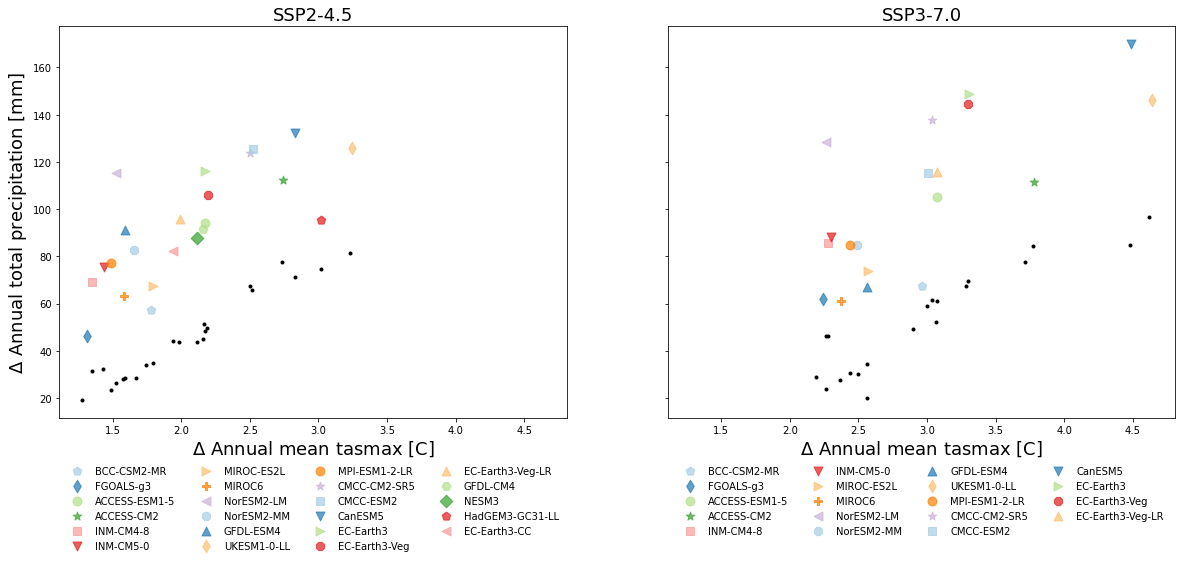

In [135]:
print(wtype)
# TODO create a frame outside of the fig for the legend

fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)
scen = "ssp245"
tplt = tgm[scen].sel(weighting=wtype)["annual_average_tasmax"] - 273.15
pplt = pgm[scen].sel(weighting=wtype)["total_annual_precip"]

annotations = models45
markers = itertools.cycle(markerlst)
colors = itertools.cycle(colorlst)

ax = axs[0]

tslice = slice(2080, 2099)
for mm in models45:

    plotx = tplt.sel(model=mm, year=tslice).mean(dim="year") - (
        thplt.sel(model=mm)
    ).sel(year=slice(1995, 2014)).mean(dim="year")
    ploty = pplt.sel(model=mm, year=tslice).mean(dim="year") - (
        phplt.sel(model=mm)
    ).sel(year=slice(1995, 2014)).mean(dim="year")
    ax.scatter(
        plotx, ploty, s=80, marker=pspec[mm][0], color=pspec[mm][1], alpha=0.7
    )  # , c=tplt.sel(year=slice(2080,2099)).year)

ax.set_xlabel("$\Delta$ Annual mean tasmax [C]", fontsize=18)
ax.set_ylabel("$\Delta$ Annual total precipitation [mm]", fontsize=18)
ax.set_title(f"SSP2-4.5", fontsize=18)  # {ttl} \n2080-2099 change relative 1995-2014

# ===
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(
    (models45),
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    frameon=False,
    fancybox=True,
    shadow=True,
    ncol=4,
)

# ===
# ADD CLEAN MODELS
if wtype == "area-weighted":  # all nans otherwise
    xplt = cltgm[scen].sel(weighting=wtype, year=tslice).mean(dim="year") - cltgm[
        "historical"
    ].sel(weighting=wtype, year=slice(1995, 2014)).mean(dim="year")

    yplt = clpgm[scen].sel(weighting=wtype, year=tslice).mean(dim="year") - clpgm[
        "historical"
    ].sel(weighting=wtype, year=slice(1995, 2014)).mean(dim="year")

    ax.scatter(
        xplt["annual_average_tasmax"],
        yplt["total_annual_precip"],
        color="k",
        marker=".",
    )

scen = "ssp370"
tplt = tgm[scen].sel(weighting=wtype)["annual_average_tasmax"] - 273.15
pplt = pgm[scen].sel(weighting=wtype)["total_annual_precip"]
annotations = models4570

ax = axs[1]
tslice = slice(2080, 2099)
for mm in models4570:

    plotx = tplt.sel(model=mm, year=tslice).mean(dim="year") - (
        thplt.sel(model=mm)
    ).sel(year=slice(1995, 2014)).mean(dim="year")
    ploty = pplt.sel(model=mm, year=tslice).mean(dim="year") - (
        phplt.sel(model=mm)
    ).sel(year=slice(1995, 2014)).mean(dim="year")
    ax.scatter(
        plotx, ploty, s=80, marker=pspec[mm][0], color=pspec[mm][1], alpha=0.7
    )  # , c=tplt.sel(year=slice(2080,2099)).year)

ax.set_xlabel("$\Delta$ Annual mean tasmax [C]", fontsize=18)
# ax.set_ylabel("$\Delta$ Annual total precipitation [mm]", fontsize=18)
ax.set_title(f"SSP3-7.0", fontsize=18)  # {ttl} \n2080-2099 change relative 1995-2014
# ===
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(
    (models4570),
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    frameon=False,
    fancybox=True,
    shadow=True,
    ncol=4,
)
# ===

# ADD CLEAN MODELS
if wtype == "area-weighted":  # all nans otherwise
    xplt = cltgm[scen].sel(weighting=wtype, year=tslice).mean(dim="year") - cltgm[
        "historical"
    ].sel(weighting=wtype, year=slice(1995, 2014)).mean(dim="year")

    yplt = clpgm[scen].sel(weighting=wtype, year=tslice).mean(dim="year") - clpgm[
        "historical"
    ].sel(weighting=wtype, year=slice(1995, 2014)).mean(dim="year")

    ax.scatter(
        xplt["annual_average_tasmax"],
        yplt["total_annual_precip"],
        color="k",
        marker=".",
    )

fig.savefig(
    f"downscaling_paper_figure10_ssp245_ssp370_{wtype}_ann_tasmax_v_totalpr_scatter_plot_2panelcolors_withclean.png",
    dpi=120,
    bbox_inches="tight",
)

### USE THIS VERSION: A version with better markers for the "clean" models

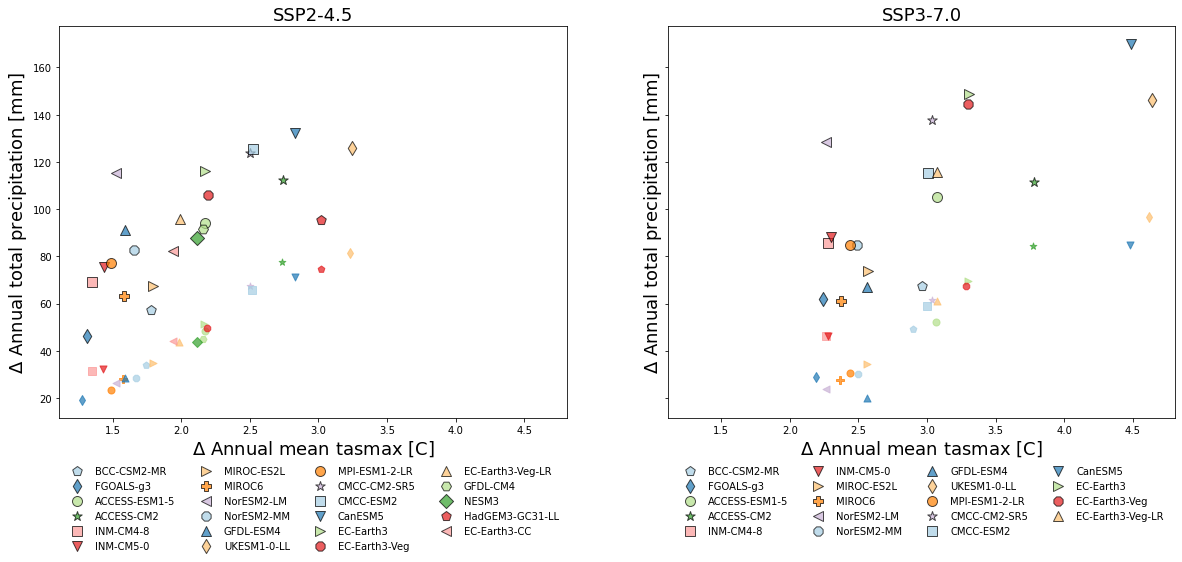

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

scen = "ssp245"
tplt = tgm[scen].sel(weighting=wtype)["annual_average_tasmax"] - 273.15
pplt = pgm[scen].sel(weighting=wtype)["total_annual_precip"]

annotations = models45
markers = itertools.cycle(markerlst) 
colors = itertools.cycle(colorlst) 

ax = axs[0]

tslice = slice(2080, 2099)
# for mm in tplt.model:
for mm in models45:
    # marker=next(markers)
    # color=next(colors)

    plotx = tplt.sel(model=mm,year=tslice).mean(dim="year") - (
        thplt.sel(model=mm)
    ).sel(year=slice(1995, 2014)).mean(dim="year")
    ploty = pplt.sel(model=mm,year=tslice).mean(dim="year") - (
        phplt.sel(model=mm)
    ).sel(year=slice(1995, 2014)).mean(dim="year")

    ax.scatter(plotx, ploty, s=100, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7,
               edgecolors="k")  

# ===
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend((models45),loc='upper center', bbox_to_anchor=(0.5, -0.1),
          frameon=False,fancybox=True, shadow=True, ncol=4)
# ===
for mm in models45:
    
    plotclx = (cltgm[scen].sel(model=mm,weighting=wtype,year=tslice).mean(dim="year") 
            - cltgm["historical"].sel(model=mm,weighting=wtype,year=slice(1995, 2014)).mean(dim="year") )

    plotcly = (clpgm[scen].sel(model=mm,weighting=wtype,year=tslice).mean(dim="year") 
            - clpgm["historical"].sel(model=mm,weighting=wtype,year=slice(1995, 2014)).mean(dim="year") )
    
    ax.scatter(plotclx["annual_average_tasmax"], 
               plotcly["total_annual_precip"], s=50, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7)  


# for i, label in enumerate(annotations):
#     ax.annotate(label, (plotx.values[i]+.03, ploty.values[i]+.03),fontsize=14)
ax.set_xlabel("$\Delta$ Annual mean tasmax [C]", fontsize=18)
ax.set_ylabel("$\Delta$ Annual total precipitation [mm]", fontsize=18)
ax.set_title(f"SSP2-4.5", fontsize=18) # {ttl} \n2080-2099 change relative 1995-2014


scen = "ssp370"
tplt = tgm[scen].sel(weighting=wtype)["annual_average_tasmax"] - 273.15
pplt = pgm[scen].sel(weighting=wtype)["total_annual_precip"]

annotations = models4570
markers = itertools.cycle(markerlst) 
colors = itertools.cycle(colorlst) 

ax = axs[1]

tslice = slice(2080, 2099)
# for mm in tplt.model:
for mm in models4570:
    # marker=next(markers)
    # color=next(colors)

    plotx = tplt.sel(model=mm,year=tslice).mean(dim="year") - (
        thplt.sel(model=mm)
    ).sel(year=slice(1995, 2014)).mean(dim="year")
    ploty = pplt.sel(model=mm,year=tslice).mean(dim="year") - (
        phplt.sel(model=mm)
    ).sel(year=slice(1995, 2014)).mean(dim="year")

    ax.scatter(plotx, ploty, s=100, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7,
               edgecolors="k")  

# ===
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend((models4570),loc='upper center', bbox_to_anchor=(0.5, -0.1),
          frameon=False,fancybox=True, shadow=True, ncol=4)
# ===
for mm in models4570:
    
    plotclx = (cltgm[scen].sel(model=mm,weighting=wtype,year=tslice).mean(dim="year") 
            - cltgm["historical"].sel(model=mm,weighting=wtype,year=slice(1995, 2014)).mean(dim="year") )

    plotcly = (clpgm[scen].sel(model=mm,weighting=wtype,year=tslice).mean(dim="year") 
            - clpgm["historical"].sel(model=mm,weighting=wtype,year=slice(1995, 2014)).mean(dim="year") )
    
    ax.scatter(plotclx["annual_average_tasmax"], 
               plotcly["total_annual_precip"], s=50, marker=pspec[mm][0], color=pspec[mm][1],alpha=.7)  


# for i, label in enumerate(annotations):
#     ax.annotate(label, (plotx.values[i]+.03, ploty.values[i]+.03),fontsize=14)
ax.set_xlabel("$\Delta$ Annual mean tasmax [C]", fontsize=18)
ax.set_ylabel("$\Delta$ Annual total precipitation [mm]", fontsize=18)
ax.set_title(f"SSP3-7.0", fontsize=18) # {ttl} \n2080-2099 change relative 1995-2014

fig.savefig(f"downscaling_paper_figure10_ssp245_ssp370_{wtype}_ann_tasmax_v_totalpr_scatter_plot_2panelcolors_withcleancolors.png",dpi=120,bbox_inches="tight")

In [361]:
# save Fig 10 data:
tsave45 = (
    tgm["ssp245"]
    .sel(weighting="area-weighted")["annual_average_tasmax"]
    .sel(year=slice(2080, 2099))
    .mean(dim="year")
    - tgm["historical"]
    .sel(weighting="area-weighted")["annual_average_tasmax"]
    .sel(year=slice(1995, 2014))
    .mean(dim="year")
)
tsave70 = (
    tgm["ssp370"]
    .sel(weighting="area-weighted")["annual_average_tasmax"]
    .sel(year=slice(2080, 2099))
    .mean(dim="year")
    - tgm["historical"]
    .sel(weighting="area-weighted")["annual_average_tasmax"]
    .sel(year=slice(1995, 2014))
    .mean(dim="year")
)

psave45 = (
    pgm["ssp245"]
    .sel(weighting="area-weighted")["total_annual_precip"]
    .sel(year=slice(2080, 2099))
    .mean(dim="year")
    - pgm["historical"]
    .sel(weighting="area-weighted")["total_annual_precip"]
    .sel(year=slice(1995, 2014))
    .mean(dim="year")
)
psave70 = (
    pgm["ssp370"]
    .sel(weighting="area-weighted")["total_annual_precip"]
    .sel(year=slice(2080, 2099))
    .mean(dim="year")
    - pgm["historical"]
    .sel(weighting="area-weighted")["total_annual_precip"]
    .sel(year=slice(1995, 2014))
    .mean(dim="year")
)

scatterds = xr.merge([xr.concat([tsave45,tsave70],dim=pd.Index(["ssp245","ssp370"],name="scenario")),
          xr.concat([psave45,psave70],dim=pd.Index(["ssp245","ssp370"],name="scenario"))]
        )
scatterds.attrs.update({"Method": "Difference between scenario (2080-2099 mean) global area-weighted average and historical (1995-2014 mean) global area-weighted average"})
scatterds.to_netcdf("Scatter_Figure_data.nc")

In [365]:
scatterds.max(dim="model").to_dataframe()

,weighting,annual_average_tasmax,total_annual_precip
scenario,,,
ssp245,area-weighted,3.243356,132.033332
ssp370,area-weighted,4.641723,169.857292


In [366]:
scatterds.min(dim="model").to_dataframe()

,weighting,annual_average_tasmax,total_annual_precip
scenario,,,
ssp245,area-weighted,1.316124,46.436005
ssp370,area-weighted,2.239925,61.059573


### testing an alternate scatter plot that includes all future years and models

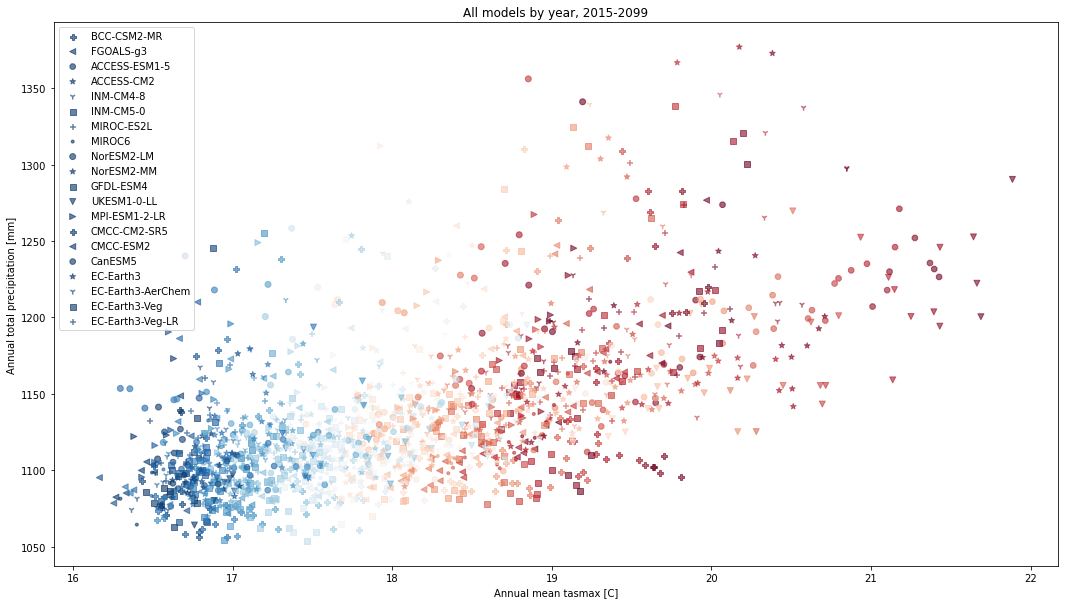

In [202]:

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
for mod in tplt.model.values:
    ax.scatter(
        tplt.sel(model=mod),
        pplt.sel(model=mod),
        alpha=0.6,
        marker=next(markers),
        c=tplt.year,
        cmap="RdBu_r",
    )

ax.set_xlabel("Annual mean tasmax [C]")
ax.set_ylabel("Annual total precipitation [mm]")
ax.set_title("All models by year, 2015-2099")
ax.legend(tplt.model.values)